In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist

In [2]:
# Hyperparameters
cuda = True
epochs = 10
log_interval = 400
batchSize = 16

hidden_layer_sizes = [256, 256, 256, 256, 256]

lr = 0.001

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc_in = nn.Linear(3 * 32 * 32, hidden_layer_sizes[0])
        self.linears = nn.ModuleList([nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]) for i in range(len(hidden_layer_sizes) - 1)])
        self.fc_out = nn.Linear(hidden_layer_sizes[-1], 10)
        
#         for i, l in enumerate(self.linears):
#             self.linears[i].weight.data.copy_(torch.eye(self.linears[i].weight.size(0)))

    def forward(self, x):
        activations = []
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc_in(x))
        activations = np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1)
        for i, l in enumerate(self.linears):
            x = F.relu(l(x))
            activations = np.append(activations, np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1), axis=1)
        x = self.fc_out(x)
        return x, activations
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (fc_in): Linear (3072 -> 256)
  (linears): ModuleList (
    (0): Linear (256 -> 256)
    (1): Linear (256 -> 256)
    (2): Linear (256 -> 256)
    (3): Linear (256 -> 256)
  )
  (fc_out): Linear (256 -> 10)
)


In [4]:
class ActivationFollower():
    
    train_activations = 0
    train_labels = 0
    
    def __init__(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def reset(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
        
    def print_metrics(self):
        Matrixes = []
        for l in range(len(hidden_layer_sizes)):
            Matrixes += [pdist(self.train_activations[:,l], metric='cityblock')]
        for l1 in range(len(hidden_layer_sizes) - 1):
            for l2 in range(1, len(hidden_layer_sizes)):
                if l1 != l2:
                    plt.hist(np.abs(Matrixes[l2] - Matrixes[l1]), label='Layers : %d - %d' % (l1 + 1, l2 + 1))
                    plt.legend()
                    avg_distance_diff = np.abs(Matrixes[l2] - Matrixes[l1]).mean()
                    avg_distance_sum = np.abs(Matrixes[l2] - Matrixes[l1]).sum()
                    covariance = np.cov(Matrixes[l1], Matrixes[l2])[0][1] / np.std(Matrixes[l1]) / np.std(Matrixes[l2])
                    print('Layers : %d %d --- Average Distance difference : %.2f, Covariance : %.2f, Sum Distance difference : %.2f' % (l1, l2, avg_distance_diff, covariance, avg_distance_sum))
        plt.title('How much the layer changes the distances of elements')
        plt.show()

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
if cuda:
    model.cuda()
    criterion.cuda()

In [7]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations, target.cpu().data.numpy())
        if batch_idx > 250:
            break
#     for batch_idx, (data, target) in enumerate(testloader):
#         if cuda:
#             data, target = data.cuda(), target.cuda()
#         data, target = Variable(data), Variable(target)
#         output, activations = model(data)
#         metrics.test_add(activations, target.cpu().data.numpy())
        
    metrics.print_metrics()

Layers : 0 1 --- Average Distance difference : 32.07, Covariance : 0.80, Sum Distance difference : 260596771.00
Layers : 0 2 --- Average Distance difference : 61.99, Covariance : 0.51, Sum Distance difference : 503721306.00
Layers : 0 3 --- Average Distance difference : 96.41, Covariance : 0.39, Sum Distance difference : 783453184.00
Layers : 0 4 --- Average Distance difference : 110.49, Covariance : 0.32, Sum Distance difference : 897894841.00
Layers : 1 2 --- Average Distance difference : 30.26, Covariance : 0.58, Sum Distance difference : 245909735.00
Layers : 1 3 --- Average Distance difference : 64.66, Covariance : 0.45, Sum Distance difference : 525433977.00
Layers : 1 4 --- Average Distance difference : 78.74, Covariance : 0.37, Sum Distance difference : 639875794.00
Layers : 2 1 --- Average Distance difference : 30.26, Covariance : 0.58, Sum Distance difference : 245909735.00
Layers : 2 3 --- Average Distance difference : 34.44, Covariance : 0.60, Sum Distance difference : 2798

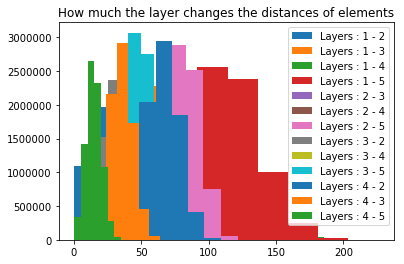

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.305326
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.303862
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.305954
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.300806
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.276538
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.138680
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.279256
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.212523

Test set: Average loss: 1.9652, Accuracy: 2672/10000 (27%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.835502
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.868881
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.781420
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.951041
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.196746
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.568693
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.921022
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.416978

Test set: Average loss: 1.6694, Accuracy: 3904/10000 (39%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.471858
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.536

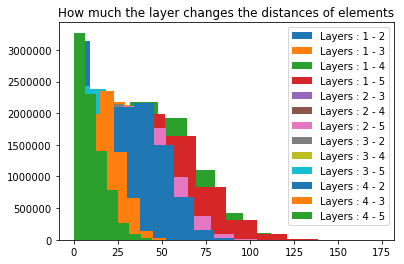

In [8]:
activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    
activation_metrics()